In [23]:
import sys
sys.path.append("/mnt/shared/Huggingface/sharedcode/Stegastamp_CR")
sys.path.append("/data/shared/Huggingface/sharedcode/Stegastamp_CR")
from utils.helpers import *
from dataset import CustomImageFolder
from torchvision import transforms
from functools import partial
import torch
from functions import *
import matplotlib.pyplot as plt
from clustering_function import text_low,text_mid,text_high
from torchvision.datasets import ImageFolder
import os
import torch
from clustering_function import cluster
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score,silhouette_score
import csv
from sklearn.metrics import pairwise_distances_argmin_min
os.environ['OPENBLAS_VERBOSE'] = '0'
# model and data setting
# set_seeds(2024)
model_choice = "hidden"
data_choice = "COCO"
mi = ""
# forge setting 
set_seeds(2024)
text_num = 4
random_sample = False
device = torch.device("cuda:7")
data_dir = {"COCO":"/data/shared/coco2017/test2017","CelebA":"/data/shared/deepfake/CelebA-HQ/val"}
ckp_dir = f"/data/shared/Huggingface/sharedcode/Stegastamp_Train/{mi}weights/{data_choice}/{model_choice}"
csv_file = f"../KM_results/oriscore/{data_choice}_{model_choice}_{'rand' if random_sample else ''}_{text_num}_{mi}.csv"
transform_pipe = [
    transforms.Resize((128,128)),
    transforms.ToTensor(),
]
if model_choice == 'hidden':
    transform_pipe.append(transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]))
transform = transforms.Compose(transform_pipe)
if data_choice == "CelebA":
    ds = ImageFolder(data_dir[data_choice],transform=transform)
else:
    ds = CustomImageFolder(data_dir[data_choice],transform,num=1000)
message_len = 100 if model_choice == "hidden" else 100

# functions
get_wmimages = partial(get_wmimages,ds=ds,device=device,model_choice=model_choice)
get_images = partial(get_images,ds=ds,device=device)
extract_message = partial(extract_message,device=device,model_choice=model_choice)

# tsne forge setting
use_vae = False
batch_size = 16
attack_num = 30


ckp_list = [f"{mi}OO"]
ckp_list = [f"{mi}GN_0.1"]
# ckp_list = [f"{mi}emperical"]
# ckp_list = [f"{mi}affine_0.01"]
# ckp_list = sorted(os.listdir(ckp_dir))
if f"{mi}OO" in ckp_list:
    ckp_list.remove(f"{mi}OO")
    ckp_list.insert(0,f"{mi}OO")
# ckp_list = ["miOO"]

text_list = [generate_message(message_len,t,1) for t in text_mid]
for op in ckp_list:
    if "scaling" in op or "combined" in op:
        continue
    if op == "OO":
        ckp_path = os.path.join(ckp_dir,op,'epoch_499_state100.pth')
    elif op == "emperical":
        ckp_path = os.path.join(ckp_dir,op,'epoch_499_state.pth')
    else:
        ckp_path = os.path.join(ckp_dir,op,'epoch_99_state.pth')
    encoder,decoder = load_weights(ckp_path,model_choice,message_len)
    # watermarked images by different text
    
    if random_sample:
        wm_images,residual_predictions = zip(*[get_wmimages(text=t,image_i=random.sample(range(1000),attack_num),encoder=encoder) for i,t in enumerate(text_list)])
    else:
        wm_images,residual_predictions = zip(*[get_wmimages(text=t,image_i=range((i)*attack_num,(i+1)*attack_num),encoder=encoder) for i,t in enumerate(text_list)])
    # 
    if use_vae:
        residual_predictions = [get_residual_prediction(wm_images_i,batch_size,device,method="VAE") for wm_images_i in wm_images]

    wm_images = list(wm_images)
    residual_predictions = list(residual_predictions)

    # TSNE
    data = torch.cat(residual_predictions,dim=0).detach().cpu()
    labels = torch.cat([torch.ones(attack_num,)*i for i in range(text_num)]).detach().numpy()
    flattened_data = data.view(text_num*attack_num,-1).numpy()

    tsne = TSNE(n_components=2, random_state=5000)
    reduced_data = tsne.fit_transform(flattened_data)

    # cluster
    cluster_labels,cluster_centers = cluster(reduced_data,text_num,"km")
    # score = homogeneity_score(labels,cluster_labels)
    score = silhouette_score(reduced_data,cluster_labels)

    _, distances = pairwise_distances_argmin_min(reduced_data, cluster_centers)
    average_distances = []
    for i in range(text_num):
        cluster_distances = distances[cluster_labels == i]
        average_distance = np.mean(cluster_distances)
        average_distances.append(average_distance)

    # 打印每个簇的平均距离
    for i, avg_distance in enumerate(average_distances):
        print(f"Cluster {i}: Average Distance to Centroid = {avg_distance:.2f}")
    print(f"model:{op}-score:{score}")

    # csv_dict = {"model":op,"score":score}
    # with open(csv_file, mode='a', newline='') as file:
    #     fieldnames = csv_dict.keys()
    #     writer = csv.DictWriter(file, fieldnames=fieldnames)
    #     if file.tell() == 0:
    #         writer.writeheader()
    #     writer.writerow(csv_dict)


Cluster 0: Average Distance to Centroid = 0.66
Cluster 1: Average Distance to Centroid = 0.68
Cluster 2: Average Distance to Centroid = 0.60
Cluster 3: Average Distance to Centroid = 0.86
model:GN_0.1-score:0.751519501209259


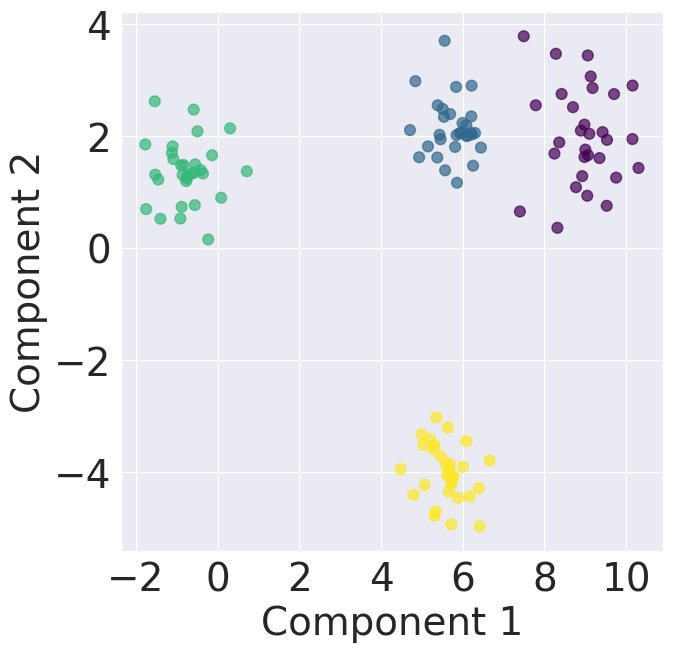

In [24]:
# plt.rcParams['font.size'] = 16
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(7, 7))
# labels_list = ['t1', 't2', 't3', 't4']
labels_list = ['Message1', 'Message2', 'Message3', 'Message4']
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.7,s=60)
handles, _ = scatter.legend_elements()
# legend1 = plt.legend(handles, labels_list,fontsize=26,ncol=1,handletextpad=0.05, columnspacing=0.05)
# plt.gca().add_artist(legend1)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
title = f"{data_choice}(HiDDeN)"
# plt.title(title,fontsize=35)
plt.xlabel('Component 1',fontsize=28)
plt.ylabel('Component 2',fontsize=28)
plt.savefig(f"{title}_cluster(GN).pdf", bbox_inches='tight')

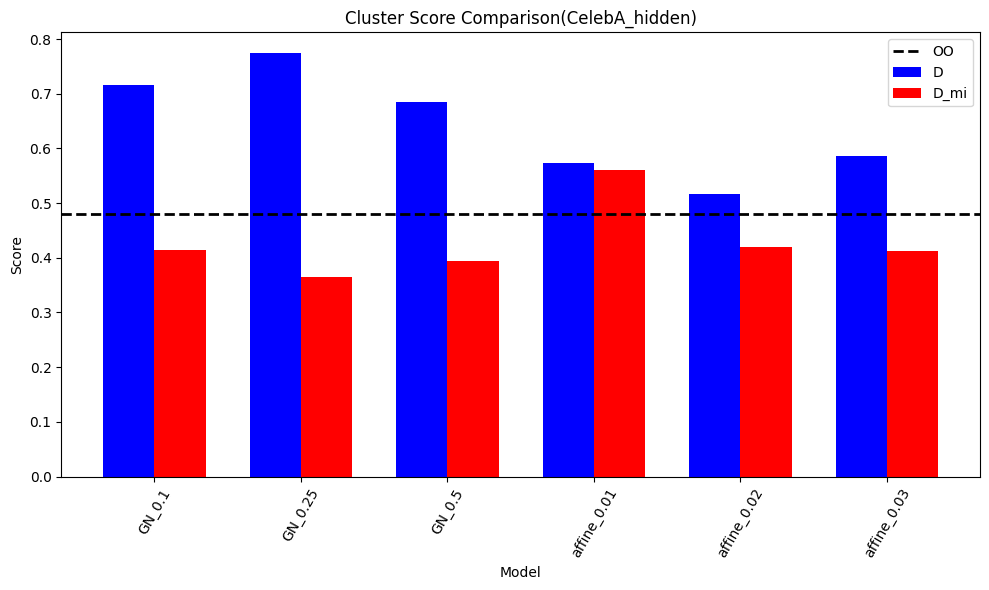

In [5]:
# plot
import pandas as pd
import matplotlib.pyplot as plt

data_choice_title = "CelebA"
model_choice_title = "hidden"
# 读取训练前的CSV文件
df_before = pd.read_csv(f'../KM_results/score/{data_choice_title}_{model_choice_title}_rand_4_.csv')
# 读取训练后的CSV文件
df_after = pd.read_csv(f'../KM_results/score/{data_choice_title}_{model_choice_title}_rand_4_mi.csv')

df_oo = df_before[df_before['model'] == 'OO']
oo_acc = df_oo['score'].values[0]

df_before = df_before[df_before['model'] != 'OO']
df_after = df_after[df_after['model'] != 'OO']

# 设置图形大小
plt.figure(figsize=(10, 6))

# 绘制柱状图
bar_width = 0.35
index = range(len(df_before))
plt.axhline(y=oo_acc, color='black', linestyle='--', linewidth=2, label='OO')
plt.bar(index, df_before['score'], bar_width, label='D',color='blue')
plt.bar([i + bar_width for i in index], df_after['score'], bar_width, label='D_mi',color='red')


# 添加标题和标签
plt.xlabel('Model')
plt.ylabel('Score')
plt.title(f'Cluster Score Comparison({data_choice_title}_{model_choice_title})')
plt.xticks([i + bar_width / 2 for i in index],list(df_before[df_before['model'] != 'OO']['model']), rotation=60)
plt.legend()

# 显示图形
plt.tight_layout()
plt.show()